In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

In [13]:
def radar_intrusion_detector(training_set_file, test_set_file, window_size, step_size):
    
    # Read the csv files and create the corresponding Dataframes
    training_set = import_csv(training_set_file)
    test_set = import_csv(test_set_file)

    # Create sliding windows and calculate statistics for dataset
    df_training = create_sliding_windows(training_set, window_size, step_size)
    df_test = create_sliding_windows(test_set, window_size, step_size)

    # Calculate upper and lower bands for each statistic
    upper_bound, lower_bound = calculate_bands(df_training)

    # Identify anomalies in the test data based on calculated bands
    anomalies = identify_anomalies(df_test, upper_bound, lower_bound)

    # Calculate the number of anomalous windows
    num_anomalous_windows = count_anomalous_windows(anomalies)

    # Print the number of anomalous windows
    print(f"Number of anomalous windows: {num_anomalous_windows}")

    # Get ground truth labels from the test DataFrame
    ground_truth_labels = ground_truth_labels_generation(df_test)

    # Get predicted labels from the anomalies DataFrame
    predicted_labels = (anomalies.values).astype(int)
    
    # Calculate metrics
    evaluation_metrics(ground_truth_labels, predicted_labels)

    # Plot data, bands, and anomalies
    plot_data(df_test, 'Num. of Packets', upper_bound, lower_bound, anomalies, ground_truth_labels)
    

In [14]:
def import_csv(file):
    
    data = pd.read_csv(file, usecols=['Time', 'Source', 'Length'])
    
    # Filter Dataframe by protocol "ASTERIX"
    #data = data[data.Protocol=='ASTERIX']
    
    # Convert the 'Time' column format in datetime format
    data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S')
    return data

In [15]:
def create_sliding_windows(data, window_size, step_size):
    
    windows = []
    current_time = data['Time'].min()

    while current_time + pd.Timedelta(seconds=window_size) <= data['Time'].max():
        window_end = current_time + pd.Timedelta(seconds=window_size)
        window_data = data[(data['Time'] >= current_time) & (data['Time'] <= window_end)]
        
        num_packets = len(window_data)
        avg_length = window_data['Length'].mean()

        windows.append([num_packets, avg_length])
        current_time += pd.Timedelta(seconds=step_size)

    columns = ['Num. of Packets', 'Avg. Length']
    df_windows = pd.DataFrame(windows, columns=columns)
    
    return df_windows

In [16]:
def calculate_bands(df_data):
    
    min_max_packets = [df_data['Num. of Packets'].min(), df_data['Num. of Packets'].max()]
    min_max_packets_std = np.std(min_max_packets)
    min_max_packets_mean = np.mean(min_max_packets)
    
    threshold_factor = 1.5
    
    upper_bound = min_max_packets_mean + threshold_factor * min_max_packets_std
    lower_bound = min_max_packets_mean - threshold_factor *  min_max_packets_std
    
    return upper_bound, lower_bound

In [17]:
def identify_anomalies(data, upper_bound, lower_bound):
    column_data = data['Num. of Packets']
    column_anomalies = (column_data > upper_bound) | (column_data < lower_bound)
    return column_anomalies

In [18]:
def count_anomalous_windows(anomalies):
    num_anomalous_windows = anomalies.sum()
    return num_anomalous_windows

In [19]:
def ground_truth_labels_generation(data):

    # Create a NumPy array of zeros
    ground_truth_labels = np.zeros(len(data))

    # Get indices of the rows where 'Avg. Length' is not equal to 588
    anomaly_indices = data['Avg. Length'] != 588
    
    # Set ground_truth_labels to 1 using indices derived above 
    ground_truth_labels[anomaly_indices] = 1
    
    return ground_truth_labels

In [20]:
def evaluation_metrics(ground_truth_labels, predicted_labels):
    
    f1 = f1_score(ground_truth_labels, predicted_labels, zero_division=1)
    recall = recall_score(ground_truth_labels, predicted_labels, zero_division=1)
    precision = precision_score(ground_truth_labels, predicted_labels, zero_division=1)
    accuracy = accuracy_score(ground_truth_labels, predicted_labels)

    print("F1 Score:", f1)
    print("Recall:", recall)
    print("Precision:", precision)
    print("Accuracy:", accuracy)

In [21]:
def plot_data(data, column_name, upper_bound, lower_bound, anomalies, ground_truth_labels):
    fig, ax = plt.subplots(figsize=(8, 4))

    column_data = data[column_name]
    column_anomalies = anomalies

    ax.plot(column_data, label=column_name)
    ax.axhline(upper_bound, color='r', linestyle='dashed', label='Upper Bound')
    ax.axhline(lower_bound, color='g', linestyle='dashed', label='Lower Bound')

    # Plot anomalies
    ax.scatter(column_data.index[column_anomalies], column_data[column_anomalies], color='red', label='Anomalies')

    # Convert the ground_truth_labels NumPy array to a pandas Series
    ground_truth_labels_series = pd.Series(ground_truth_labels)

    # Find indexes where the label is equal to 1
    windows_attack = ground_truth_labels_series.index[ground_truth_labels_series == 1]

    # Highlight the corresponding window
    if len(windows_attack) > 0:
        ax.axvspan(windows_attack[0] - 0.5, windows_attack[-1] + 0.5, facecolor=(50/255, 50/255, 50/255), alpha=0.1, label='Attack Phase')

    ax.set_xlabel('Window Index')
    ax.set_ylabel(column_name)
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


Number of anomalous windows: 187
F1 Score: 0.9756097560975611
Recall: 0.989010989010989
Precision: 0.9625668449197861
Accuracy: 0.9690721649484536


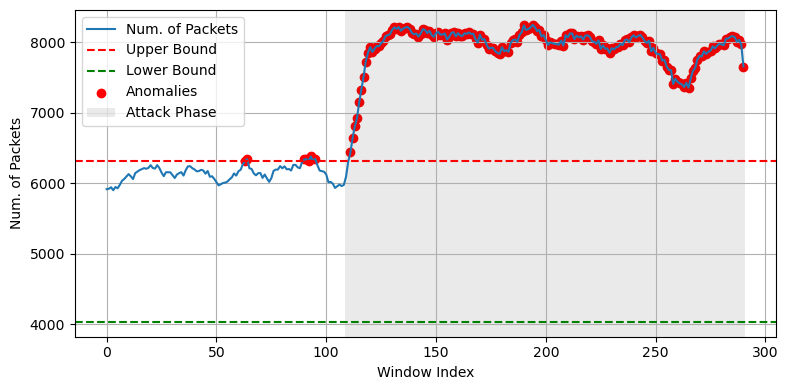

In [22]:
# Example
training_set_file = 'D:/UNIPD/Advanced_Topics/Maritime Security/Code/train_data.csv'
test_set_file = 'D:/UNIPD/Advanced_Topics/Maritime Security/Code/test_attack_200.csv'
window_size = 10 #seconds
step_size = 1 #seconds

radar_intrusion_detector(training_set_file, test_set_file, window_size, step_size)